In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

pd.set_option('display.max_columns', None)

file_path = os.path.join(os.path.dirname(sys.path[0]), 'clean_data/gurgaon_properties_imputed.csv')
df = pd.read_csv(file_path)

df.drop(columns=['pooja room', 'study room', 'others', 'society', 'price_per_sqft'], inplace=True)

def cat_luxury_score(score):
    if score < 50:
        return 'Low'
    elif score < 150:
        return 'Medium'
    elif score >= 150:
        return 'High'
    else:
        return np.nan
    
def cat_floorNum(floor):
    if 0 <= floor <= 2:
        return 'Low Floor'
    elif floor <= 10:
        return 'Medium Floor'
    elif floor <= 51:
        return 'High Floor'
    else:
        return np.nan

df['luxury_score'] = df['luxury_score'].apply(cat_luxury_score)
df['floorNum'] = df['floorNum'].apply(cat_floorNum)

df.sample(5)

,property_type,sector,price,bedroom,bathroom,balcony,floorNum,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_score
2138,flat,sector 86,0.82,2,2,1,High Floor,New Property,1300.000000,0,0,0,Low
1264,house,sector 66,15.10,5,5,3+,Medium Floor,New Property,8067.800000,1,1,0,Medium
1888,flat,sector 92,0.51,3,2,2,Low Floor,Relatively New,1130.952381,0,0,0,Medium
774,flat,sector 67a,1.50,2,2,2,Medium Floor,Relatively New,1500.000000,0,1,2,Low
3194,flat,sector 90,1.19,3,3,2,High Floor,Relatively New,1561.619048,0,0,0,Medium


/tmp/ipykernel_4692/1616884911.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y)
/tmp/ipykernel_4692/1616884911.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['price'])


<Axes: xlabel='price', ylabel='Density'>

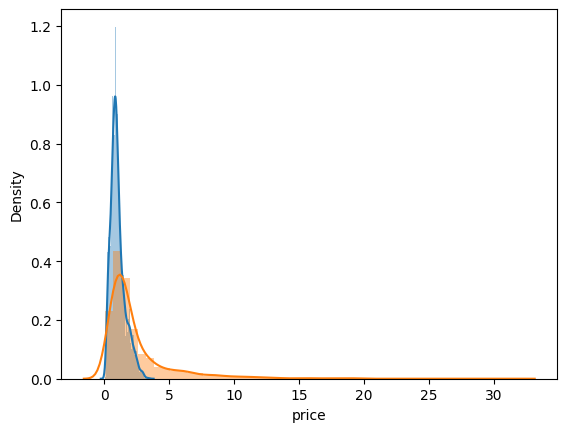

In [2]:
x = df.drop(columns=['price'])
y = np.log1p(df['price'])

sns.distplot(y)
sns.distplot(df['price'])


In [5]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.neural_network import *
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import category_encoders as ce

In [4]:
x.dtypes

property_type       object
sector              object
bedroom              int64
bathroom             int64
balcony             object
floorNum            object
agePossession       object
built_up_area      float64
servant room         int64
store room           int64
furnishing_type      int64
luxury_score        object
dtype: object

In [5]:
col_encod = ['property_type', 'sector', 'balcony', 'floorNum','agePossession','furnishing_type', 'luxury_score']

# Ordinal Encoding

In [6]:
def model_scores_ord(model_name, model, x, y):
    
    output = []
    for col in ['property_type', 'sector', 'balcony', 'floorNum','agePossession','furnishing_type', 'luxury_score']:
        oe = OrdinalEncoder(dtype=np.int64)
        x[col] = oe.fit_transform(x[[col]])
        
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedroom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
    ], remainder='passthrough'  
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (f'{model_name}', model)
    ]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, x, y, cv = kfold, scoring='r2')
    
    scores_mean = scores.mean()
    
    pipeline.fit(x_train, y_train)
    
    y_pred = np.expm1(pipeline.predict(x_test))
    
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    
    output.extend((model_name, scores_mean, mae))
    
    return output

In [7]:
model_dict = {
    'linear reg': LinearRegression(),
    'svr': SVR(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'decision tree': DecisionTreeRegressor(),
    'random forest': RandomForestRegressor(),
    'extra trees': ExtraTreeRegressor(),
    'gradient boosting': GradientBoostingRegressor(),
    'adaboost': AdaBoostRegressor(),
    'mlp': MLPRegressor(),
    'xgboost': XGBRegressor()
}


In [8]:
model_output_ord = []
for model_name,model in model_dict.items():
    model_output_ord.append(model_scores_ord(model_name, model, x, y))
    
model_output_ord

/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[['linear reg', 0.736916702912921, 1.0270681292831303],
 ['svr', 0.758026795862601, 0.8583419267299043],
 ['ridge', 0.7369192252342721, 1.0267757987141324],
 ['lasso', 0.056693830859752006, 1.4901969064735952],
 ['decision tree', 0.7880005226569343, 0.6903335422059078],
 ['random forest', 0.883202017108724, 0.5125167417487753],
 ['extra trees', 0.7251293163537853, 0.8389946696558298],
 ['gradient boosting', 0.8781319919398831, 0.5815637835269211],
 ['adaboost', 0.7596618837226333, 0.8798091385985006],
 ['mlp', 0.8099394452291895, 0.7213473145471943],
 ['xgboost', 0.8931873732517539, 0.5104208281682346]]

In [9]:
model_df_ord = pd.DataFrame(model_output_ord, columns=['model', 'r2_score', 'mae']).sort_values(by='mae')
model_df_ord

,model,r2_score,mae
10,xgboost,0.893187,0.510421
5,random forest,0.883202,0.512517
7,gradient boosting,0.878132,0.581564
4,decision tree,0.788001,0.690334
9,mlp,0.809939,0.721347
6,extra trees,0.725129,0.838995
1,svr,0.758027,0.858342
8,adaboost,0.759662,0.879809
2,ridge,0.736919,1.026776
0,linear reg,0.736917,1.027068


# One Hot Encoding

In [10]:
def model_scores_ohe(model_name, model, x, y):
    
    output = []
    for col in ['property_type', 'sector', 'balcony', 'floorNum','agePossession','furnishing_type', 'luxury_score']:
        oe = OrdinalEncoder(dtype=np.int64)
        x[col] = oe.fit_transform(x[[col]])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedroom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(handle_unknown = 'ignore', drop='first'), ['sector', 'agePossession', 'furnishing_type'])
    ], remainder='passthrough'  
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (f'{model_name}', model)
    ]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, x, y, cv = kfold, scoring='r2')
    
    scores_mean = scores.mean()
    
    pipeline.fit(x_train, y_train)
    
    y_pred = np.expm1(pipeline.predict(x_test))
    
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    
    output.extend((model_name, scores_mean, mae))
    
    return output

In [11]:
model_output_ohe = []
for model_name,model in model_dict.items():
    model_output_ohe.append(model_scores_ohe(model_name, model, x, y))
    
model_output_ohe

/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. The

[['linear reg', 0.8564635794316058, 0.7329161113938457],
 ['svr', 0.8845221835169861, 0.5585443438894029],
 ['ridge', 0.8566648961403228, 0.7412031924423844],
 ['lasso', -0.0011884581765496227, 1.5035304494444033],
 ['decision tree', 0.783802600995501, 0.6775221911045741],
 ['random forest', 0.8761445724813403, 0.5381228990955684],
 ['extra trees', 0.7947792884272137, 0.6750146875113542],
 ['gradient boosting', 0.860545105650574, 0.6188886715786825],
 ['adaboost', 0.7319051408620144, 0.8736737990214827],
 ['mlp', 0.8780879861573492, 0.556508257174191],
 ['xgboost', 0.8919715986417301, 0.5271419300535057]]

In [12]:
model_df_ohe = pd.DataFrame(model_output_ohe, columns=['model', 'r2_score', 'mae']).sort_values(by='mae')
model_df_ohe

,model,r2_score,mae
10,xgboost,0.891972,0.527142
5,random forest,0.876145,0.538123
9,mlp,0.878088,0.556508
1,svr,0.884522,0.558544
7,gradient boosting,0.860545,0.618889
6,extra trees,0.794779,0.675015
4,decision tree,0.783803,0.677522
0,linear reg,0.856464,0.732916
2,ridge,0.856665,0.741203
8,adaboost,0.731905,0.873674


# PCA

In [13]:
def model_scores_pca(model_name, model, x, y):
    
    output = []
    for col in ['property_type', 'sector', 'balcony', 'floorNum','agePossession','furnishing_type', 'luxury_score']:
        oe = OrdinalEncoder(dtype=np.int64)
        x[col] = oe.fit_transform(x[[col]])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedroom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(handle_unknown = 'ignore', drop='first', sparse_output=False), ['sector', 'agePossession', 'furnishing_type'])
    ], remainder='passthrough'  
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=0.95)),
        (f'{model_name}', model)
    ]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, x, y, cv = kfold, scoring='r2')
    
    scores_mean = scores.mean()
    
    pipeline.fit(x_train, y_train)
    
    y_pred = np.expm1(pipeline.predict(x_test))
    
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    
    output.extend((model_name, scores_mean, mae))
    
    return output

In [14]:
model_output_pca = []
for model_name,model in model_dict.items():
    model_output_pca.append(model_scores_pca(model_name, model, x, y))
    
model_output_pca

/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. The

[['linear reg', 0.7654221133666717, 0.9949326783031822],
 ['svr', 0.8259731548116379, 0.7040132899359698],
 ['ridge', 0.7654691793669295, 0.9942957053337445],
 ['lasso', -0.0011884581765496227, 1.5035304494444033],
 ['decision tree', 0.6523139579487258, 0.9222082211747473],
 ['random forest', 0.8277445395681573, 0.6892924739051597],
 ['extra trees', 0.628597628806894, 1.0675393648428202],
 ['gradient boosting', 0.8271069272641333, 0.7404433351261407],
 ['adaboost', 0.691709603255805, 0.923202610615758],
 ['mlp', 0.8263422110120928, 0.7041472364018575],
 ['xgboost', 0.8357465153951708, 0.6712785612748813]]

In [15]:
model_df_pca = pd.DataFrame(model_output_pca, columns=['model', 'r2_score', 'mae']).sort_values(by='mae')
model_df_pca

,model,r2_score,mae
10,xgboost,0.835747,0.671279
5,random forest,0.827745,0.689292
1,svr,0.825973,0.704013
9,mlp,0.826342,0.704147
7,gradient boosting,0.827107,0.740443
4,decision tree,0.652314,0.922208
8,adaboost,0.691710,0.923203
2,ridge,0.765469,0.994296
0,linear reg,0.765422,0.994933
6,extra trees,0.628598,1.067539


# Target Encoding

In [16]:
def model_scores_target(model_name, model, x, y):
    
    output = []
    for col in ['property_type', 'sector', 'balcony', 'floorNum','agePossession','furnishing_type', 'luxury_score']:
        oe = OrdinalEncoder(dtype=np.int64)
        x[col] = oe.fit_transform(x[[col]])
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedroom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(handle_unknown = 'ignore', drop='first', sparse_output=False), ['agePossession', 'furnishing_type']),
        ('target', ce.TargetEncoder(), ['sector'])
    ], remainder='passthrough'  
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        (f'{model_name}', model)
    ]
    )

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, x, y, cv = kfold, scoring='r2')
    
    scores_mean = scores.mean()
    
    pipeline.fit(x_train, y_train)
    
    y_pred = np.expm1(pipeline.predict(x_test))
    
    mae = mean_absolute_error(np.expm1(y_test), y_pred)
    
    output.extend((model_name, scores_mean, mae))
    
    return output

In [17]:
model_output_target = []
for model_name,model in model_dict.items():
    model_output_target.append(model_scores_target(model_name, model, x, y))
    
model_output_target

/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[['linear reg', 0.7436345194944709, 1.0209144048021057],
 ['svr', 0.7583528328575346, 0.8559574778952435],
 ['ridge', 0.743642188852691, 1.0205906648029557],
 ['lasso', 0.056693830859752006, 1.4901969064735952],
 ['decision tree', 0.7874524461503558, 0.6739461739019549],
 ['random forest', 0.8828219507135557, 0.5122457065596145],
 ['extra trees', 0.7227613576082181, 0.8297789351205462],
 ['gradient boosting', 0.8776962738223105, 0.5772235713337088],
 ['adaboost', 0.7585823673553669, 0.8561122643924619],
 ['mlp', 0.8108605590970912, 0.7721935550934879],
 ['xgboost', 0.8929630791071709, 0.5097835333071093]]

In [18]:
model_df_target = pd.DataFrame(model_output_target, columns=['model', 'r2_score', 'mae']).sort_values(by='mae')
model_df_target

,model,r2_score,mae
10,xgboost,0.892963,0.509784
5,random forest,0.882822,0.512246
7,gradient boosting,0.877696,0.577224
4,decision tree,0.787452,0.673946
9,mlp,0.810861,0.772194
6,extra trees,0.722761,0.829779
1,svr,0.758353,0.855957
8,adaboost,0.758582,0.856112
2,ridge,0.743642,1.020591
0,linear reg,0.743635,1.020914


# Hyperparameter Tuning

In [19]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
    'regressor__max_features': ['auto', 'sqrt']
}

for col in col_encod:
    oe = OrdinalEncoder(dtype=np.int64)
    x[col] = oe.fit_transform(x[[col]])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedroom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat2', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), ['agePossession', 'furnishing_type']),
        ('target', ce.TargetEncoder(), ['sector'])
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
search = GridSearchCV(pipeline, param_grid=param_grid, cv = kfold, scoring='r2', n_jobs=-1, verbose=4)

search.fit(x, y)

Fitting 10 folds for each of 128 candidates, totalling 1280 fits


[CV 1/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.0s
[CV 5/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.0s
[CV 6/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.0s
[CV 7/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.0s
[CV 8/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.0s
[CV 9/10] END regressor__max_depth=None, regressor__max_features=auto, regressor__max_samples=0.1, regressor__n_estimators=50;, score=nan total time=   0.0s
[CV 10/10] END regressor__max_depth=None, regressor__max_f

/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
640 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
640 fits failed with the following error:
Traceback (most recent call last):
  File "/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/himanshu/Projects/ML_Proj/PropertyApp/propertyapp/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/himanshu/Projects/ML_Proj

GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['bedroom',
                                                                          'bathroom',
                                                                          'built_up_area',
                                                                          'servant '
                                                                          'room',
                                                                          'store '
                                                                          'room']),
                                                                        ('cat2',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore',
                                                                                       sparse_output=False),
                                                                         ['agePossession',
                                                                          'furnishing_type']),
                                                                        ('target',
                                                                         TargetEncoder(),
                                                                         ['sector'])])),
                                       ('regressor', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['auto', 'sqrt'],
                         'regressor__max_samples': [0.1, 0.25, 0.5, 1.0],
                         'regressor__n_estimators': [50, 100, 200, 300]},
             scoring='r2', verbose=4)

In [21]:
final_pipe = search.best_estimator_

In [22]:
search.best_params_

{'regressor__max_depth': 30,
 'regressor__max_features': 'sqrt',
 'regressor__max_samples': 1.0,
 'regressor__n_estimators': 300}

In [23]:
search.best_score_

0.8559261182300558

In [24]:
final_pipe.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bedroom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat2',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type']),
                                                 ('target', TargetEncoder(),
                                        

In [45]:
x = df.drop(columns=['price'])
y = np.log1p(df['price'])

for col in col_encod:
    oe = OrdinalEncoder(dtype=np.int64)
    x[col] = oe.fit_transform(x[[col]])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

final_pipe.fit(x_train, y_train)

y_pred = np.expm1(final_pipe.predict(x_test))

mae = mean_absolute_error(np.expm1(y_test), y_pred)

mae

0.5980543292970126

# Final

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.ensemble import *
from sklearn.neural_network import *
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import category_encoders as ce

In [25]:
file_path = os.path.join(os.path.dirname(sys.path[0]), 'clean_data/gurgaon_properties_imputed.csv')
df = pd.read_csv(file_path)

df.drop(columns=['pooja room', 'study room', 'others', 'society', 'price_per_sqft'], inplace=True)

def cat_luxury_score(score):
    if score < 50:
        return 'Low'
    elif score < 150:
        return 'Medium'
    elif score >= 150:
        return 'High'
    else:
        return np.nan
    
def cat_floorNum(floor):
    if 0 <= floor <= 2:
        return 'Low Floor'
    elif floor <= 10:
        return 'Medium Floor'
    elif floor <= 51:
        return 'High Floor'
    else:
        return np.nan

def cat_furnishing_type(furn_type):
    if furn_type == 0:
        return 'Unfurnished'
    elif furn_type == 1:
        return 'Semifurnished'
    elif furn_type == 2:
        return 'Fullyfurnished'
    else:
        return np.nan

df['luxury_score'] = df['luxury_score'].apply(cat_luxury_score)
df['floorNum'] = df['floorNum'].apply(cat_floorNum)
df['furnishing_type'] = df['furnishing_type'].apply(cat_furnishing_type)


x = df.drop(columns=['price'])
y = df['price']

In [26]:
preprocessor_final = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedroom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat1', OrdinalEncoder(dtype=np.int64), ['property_type', 'sector', 'balcony', 'floorNum','agePossession','furnishing_type', 'luxury_score']),
        ('cat2', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), ['agePossession', 'furnishing_type']),
        ('target', ce.TargetEncoder(), ['sector'])
    ]
)

pipeline_final = Pipeline([
    ('preprocessor', preprocessor_final),
    ('regressor', RandomForestRegressor(max_depth=30, max_features='sqrt', max_samples=1.0,n_estimators=500))
])

#RandomForestRegressor(max_depth=30, max_features='sqrt', max_samples=1.0,n_estimators=500)

In [27]:
pipeline_final.fit(x, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['bedroom', 'bathroom',
                                                   'built_up_area',
                                                   'servant room',
                                                   'store room']),
                                                 ('cat1',
                                                  OrdinalEncoder(dtype=<class 'numpy.int64'>),
                                                  ['property_type', 'sector',
                                                   'balcony', 'floorNum',
                                                   'agePossession',
                                                   'furnishing_type',
                                                   'luxury_score']),
                                                 ('cat2',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['agePossession',
                                                   'furnishing_type']),
                                                 ('target', TargetEncoder(),
                                                  ['sector'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       max_samples=1.0, n_estimators=500))])

In [33]:
import pickle

final_data_path = os.path.join(os.path.dirname(sys.path[0]), 'final_model_data')

with open(f'{final_data_path}/pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline_final, file)
    
with open(f'{final_data_path}/df.pkl', 'wb') as file:
    pickle.dump(x, file)
    
with open(f'{final_data_path}/sectors.pkl', 'wb') as file:
    pickle.dump(list(set(x['sector'].values)), file)

In [38]:
set(x['sector'].values)

{'dwarka expressway',
 'gwal pahari',
 'manesar',
 'sector 1',
 'sector 102',
 'sector 103',
 'sector 104',
 'sector 105',
 'sector 106',
 'sector 107',
 'sector 108',
 'sector 109',
 'sector 10a',
 'sector 11',
 'sector 110',
 'sector 111',
 'sector 112',
 'sector 113',
 'sector 12',
 'sector 13',
 'sector 14',
 'sector 15',
 'sector 17',
 'sector 17a',
 'sector 17b',
 'sector 2',
 'sector 21',
 'sector 22',
 'sector 23',
 'sector 24',
 'sector 25',
 'sector 26',
 'sector 27',
 'sector 28',
 'sector 3',
 'sector 3 phase 2',
 'sector 3 phase 3 extension',
 'sector 30',
 'sector 31',
 'sector 33',
 'sector 36',
 'sector 36a',
 'sector 37',
 'sector 37c',
 'sector 37d',
 'sector 38',
 'sector 39',
 'sector 4',
 'sector 40',
 'sector 41',
 'sector 43',
 'sector 45',
 'sector 46',
 'sector 47',
 'sector 48',
 'sector 49',
 'sector 5',
 'sector 50',
 'sector 51',
 'sector 52',
 'sector 53',
 'sector 54',
 'sector 55',
 'sector 56',
 'sector 57',
 'sector 58',
 'sector 59',
 'sector 6',
 'se